# Raport dotyczący badania popularności utworów ze <font color='green'>Spotify</font>

Importowanie niezbędnych do przeprowadzenia analizy modułów i funkcji.

In [69]:
## Scraping from spotify Web API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from dotenv import load_dotenv
import os

## Storing and reading data
import json

## Visualisation
import seaborn as sns 
import matplotlib.pyplot as plt 

## Data structures
import pandas as pd
import numpy as np # also statistics and math

### Preprocessing
# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Models
# Splitting dataset
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# model classes
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# evaluation
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


## Scrapowanie danych z <font color='green'>Web API Spotify</font>

Ładowanie zmiennych środowiskowych umieszczonych w pliku *.env*  -  ```CLIENT_SECRET``` oraz ```CLIENT_ID``` - służą one weryfikacji użytkownika oraz przydzieleniu mu tokenu, za pomocą którego może on wysyłać requesty o dane.

In [4]:
load_dotenv()

True

Korzystając z wyżej wymienionych zmiennych środowiskowych tworzony jest obiekt klasy ```SpotifyClientCredentials``` zaimportowanej z biblioteki <font color='green'>spotipy</font>.<br>
Stworzona instancja następnie przekazywana jest jako argument konstruktora obiektu klasy ```spotipy.Spotify``` - *sp*.
 

In [5]:
# data associated with the client
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

# creating spotify client
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Scrapowanie danych o utworach

Instancja *sp* posiada metodę ```recommendations()```, która umożliwia pobranie rekomendacji utworów.<br>
Jej parametry, to:
*   <font color='orange'>limit</font> - limit ściągniętych utworów za jednym requestem *(max 100)*
*   <font color='orange'>seed_genres</font> - gatunki, z których będziemy pozyskiwali utwory *(max 5)*
*   <font color='orange'>country</font> - dwuliterowy kod specyfikujący kraj, w którym utwory są dostępne
*   <font color='orange'>min_pop</font> - minimalna popularność zescrapowanych utworów *(min=0)*
*   <font color='orange'>max_pop</font> - maksymalna popularność zescrapowanych utworów *(max=100)*<br><br>
Dla każdego <font color='orange'>seed_genres</font> zawierającego *5* gatunków jest dostępna pewna pula utworów, które można uzyskać za pomocą żądań (zazwyczaj około 700). Zważając na to ograniczenie, aby uzyskać większą liczbę danych rozsądnym wydaje się zwiększenie zbioru gatunków z którego wybieramy utwory. Dla niżej wymienionych *25* gatunków optymalna liczba utworów jest określona za pomocą zmiennej ```tracks_per_seed_genres```.<br> Ostatczena liczba utworów jakie można pobrać w ten sposób przy danej liczbie gatunków oraz ```tracks_per_seed_genres``` jest przechowywana w zmiennej ```tracks_count```.

In [1]:

# filters used in requests
limit = 100
seed_genres_list = [
    ["pop", "metal", "hip-hop", "rock", "r-n-b"],
    ["punk", "acoustic", "chill", "jazz", "party"],
    ["children", "heavy-metal", "folk", "electro", "k-pop"],
    ["dance", "alternative", "soul", "house", "reggae"],
    ["country", "disco", "rock-n-roll", "techno", "salsa"],
]
country = "US"
min_pop = 0
max_pop = 100

# tracks count per each seed_genres list in seed_genres
tracks_per_seed_genres = 700
tracks_count = tracks_per_seed_genres * len(seed_genres_list)

# data structures to store scrapped tracks
tracks_set = set()
tracks_list = []

# sending requests until the 'tracks_count' value is reached
for seed_genres in seed_genres_list:
    tracks_per_seed_count = 0
    while tracks_per_seed_count < tracks_per_seed_genres:
        # sending request using defined filters
        recommendations = sp.recommendations(
            seed_genres=seed_genres,
            limit=limit,
            country=country,
            min_popularity=min_pop,
            max_popularity=max_pop,
        )
        # saving raw and unique tracks in tracks_list
        for track in recommendations["tracks"]:
            track_id = track["id"]
            if track_id not in tracks_set:
                tracks_per_seed_count += 1
                tracks_set.add(track_id)
                tracks_list.append(track)

        if tracks_per_seed_count >= tracks_per_seed_genres:
            break


Zapis zescrapowanych utworów do pliku *tracks.json*

In [ ]:
# saving raw tracks data into tracks.json file
with open('tracks.json', 'w') as file:
    json.dump(tracks_list, file, indent=4)  

Ładowanie zescrapowanych danych utworów z pliku w formacie json do pythonowej listy *tracks_list*:

In [3]:
# loading tracks
with open('tracks.json') as file:
    tracks_list = json.load(file)

### Analiza zescrapowanych danych o utworach:

Przedstawienie danych zawartych w obiekcie utworu:

In [ ]:
tracks_list[0]

{'album': {'album_group': 'ALBUM',
  'album_type': 'ALBUM',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4n31svBA9GGIYxGxgrQaRK'},
    'href': 'https://api.spotify.com/v1/artists/4n31svBA9GGIYxGxgrQaRK',
    'id': '4n31svBA9GGIYxGxgrQaRK',
    'name': 'George Thorogood & The Destroyers',
    'type': 'artist',
    'uri': 'spotify:artist:4n31svBA9GGIYxGxgrQaRK'}],
  'external_urls': {'spotify': 'https://open.spotify.com/album/2YeoeDa3soxjD4ANZGG1fj'},
  'href': 'https://api.spotify.com/v1/albums/2YeoeDa3soxjD4ANZGG1fj',
  'id': '2YeoeDa3soxjD4ANZGG1fj',
  'images': [{'height': 640,
    'url': 'https://i.scdn.co/image/ab67616d0000b273ff4db4dae0252068fc3db08f',
    'width': 640},
   {'height': 300,
    'url': 'https://i.scdn.co/image/ab67616d00001e02ff4db4dae0252068fc3db08f',
    'width': 300},
   {'height': 64,
    'url': 'https://i.scdn.co/image/ab67616d00004851ff4db4dae0252068fc3db08f',
    'width': 64}],
  'is_playable': True,
  'name': 'BAD TO THE BONE'

Po wstępnej analizie obiektu utworu można z niego wyodrębnić następujące atrybuty:
*   **```track_name```** - nazwa utworu
*   **```track_id```** - ID utworu
*   **```artists```** - nazwy artystów tworzących utwór
*   **```artists_ids```** - ID artystów tworzących utwór
*   **```album_name```** - nazwa albumu
*   **```album_id```** - ID albumu
*   **```duration_ms```** - długość trwania utworu (w ms)
*   **```explicit```** - wartość logiczna określająca czy utwór zawiera treści wulgarne, obraźliwe lub nieodpowiednie dla niektórych odbiorców
*   **```popularity```** - popularność utworu (którą zamierzamy badać)


In [7]:

# list for storing tracks with simplified data
tracks = []

# retrieving data from 'tracks_list' and saving their simplified version in 'tracks'
for track in tracks_list:
    track_data = {
        'track_name' : track["name"],
        'track_id' : track["id"],
        'artists': [artist["name"] for artist in track["artists"]],
        'artists_ids' : [artist["id"] for artist in track["artists"]],
        'album_name' : track["album"]["name"],
        'album_id': track["album"]["id"],
        "duration_ms" : track["duration_ms"],
        "explicit" : track["explicit"],
        "popularity" : track["popularity"]
    }
    tracks.append(track_data)

# creating 'pd.DataFrame' data structure for a better view of the data
tracks_df = pd.DataFrame(tracks)
tracks_df.head()


,track_name,track_id,artists,artists_ids,album_name,album_id,duration_ms,explicit,popularity
0,Bad To The Bone,6s0NHplywwr1IjnQpUpWJk,[George Thorogood & The Destroyers],[4n31svBA9GGIYxGxgrQaRK],BAD TO THE BONE,2YeoeDa3soxjD4ANZGG1fj,292173,False,72
1,"10,000 Hours",6d1fGqMtdUEuHqFSDMlR0N,[Ella Mai],[7HkdQ0gt53LP4zmHsL0nap],CHANGE,5OEG0kAfeWe5Lze9RGbJHb,230240,True,52
2,Praying,0jdny0dhgjUwoIp5GkqEaA,[Kesha],[6LqNN22kT3074XbTVUrhzX],Rainbow,1IYVB8NfiRqhdZlTxjspNh,230266,False,71
3,Rent Money,5W9QCBJ6Em0XWX333YrNhc,[Future],[1RyvyyTE3xzB2ZywiAwp0i],FUTURE,17FBoXK1NU2rvJBbzdzw0r,265366,True,59
4,Motivation,6rbhWExtuchhpLC5fHnB8n,"[Kelly Rowland, Lil Wayne]","[3AuMNF8rQAKOzjYppFNAoB, 55Aa2cqylxrFIXC767Z865]",Here I Am (Deluxe Version),673D6VTmxJquUg31Wq1j0S,230560,False,65


<font color='red'>Spostrzeżenie:</font><br>
Po przetworzeniu danych zawartych w obiekcie utworu można zauważyć, iż **nie są** one wystarczające do przeprowadzenia analizy popularności utworów. 
Pozostaje jednak możliwość wzbogacenia datasetu o dodatkowe dane o artystach (*artists_ids*) oraz albumie (*album_id*), które są powiązane z konkretnym utworem.

### Scrapowanie danych o albumach oraz artystach

Scrapowanie danych o albumie dla każdego utworu w zbiorze danych:

In [ ]:
# data structures to store raw data of scraped albums
albums_list = []
albums_ids = set()

# loop used for scraping album data by its id and adding it to the albums_list.
for track in tracks:
    album = sp.album(track["album_id"])
    id = album["id"]
    if id not in albums_ids:
        albums_ids.add(id)
        albums_list.append(album)

Zapis zescrapowanych albumów do pliku *albums.json*

In [ ]:
# saving raw albums data into albums.json file
with open('albums.json', 'w') as file:
    json.dump(albums_list, file, indent=4)

Scrapowanie danych o artyście/artystach dla każdego utworu w zbiorze danych:

In [ ]:
# data structures to store raw data of scraped artists
artists_list = []
artists_ids = set()

# loop used for scraping artist data by theirs id and adding them to the artists_list.
for track in tracks:
    artists = [sp.artist(artist_id) for artist_id in track["artists_ids"]]
    for artist in artists:
        id = artist["id"]
        if id not in artists_ids:
            artists_ids.add(id)
            artists_list.append(artist)

Zapis zescrapowanych artystów do pliku *artists.json*

In [ ]:
# saving raw artists data into artists.json file
with open('artists.json', 'w') as file:
    json.dump(artists_list, file, indent=4)

Ładowanie zescrapowanych danych albumów oraz artystów z plików w formacie json do pythonowych list:

In [4]:
# loading albums
with open('albums.json') as file:
    albums_list = json.load(file)

# loading artists
with open('artists.json') as file:
    artists_list = json.load(file)

### Analiza zescrapowanych danych o albumach:

Przedstawienie danych zawartych w obiekcie albumu:

In [ ]:
albums_list[0]

{'album_type': 'album',
 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4n31svBA9GGIYxGxgrQaRK'},
   'href': 'https://api.spotify.com/v1/artists/4n31svBA9GGIYxGxgrQaRK',
   'id': '4n31svBA9GGIYxGxgrQaRK',
   'name': 'George Thorogood & The Destroyers',
   'type': 'artist',
   'uri': 'spotify:artist:4n31svBA9GGIYxGxgrQaRK'}],
 'available_markets': ['AD',
  'AE',
  'AG',
  'AL',
  'AM',
  'AO',
  'AR',
  'AT',
  'AU',
  'AZ',
  'BA',
  'BB',
  'BD',
  'BE',
  'BF',
  'BG',
  'BH',
  'BI',
  'BJ',
  'BN',
  'BO',
  'BR',
  'BS',
  'BT',
  'BW',
  'BY',
  'BZ',
  'CA',
  'CD',
  'CG',
  'CH',
  'CI',
  'CL',
  'CM',
  'CO',
  'CR',
  'CV',
  'CW',
  'CY',
  'CZ',
  'DE',
  'DJ',
  'DK',
  'DM',
  'DO',
  'DZ',
  'EC',
  'EE',
  'EG',
  'ES',
  'ET',
  'FI',
  'FJ',
  'FM',
  'FR',
  'GA',
  'GB',
  'GD',
  'GE',
  'GH',
  'GM',
  'GN',
  'GQ',
  'GR',
  'GT',
  'GW',
  'GY',
  'HK',
  'HN',
  'HR',
  'HT',
  'HU',
  'ID',
  'IE',
  'IL',
  'IN',
  'IQ',
  'IS',


Przydatną w analizie popularności utworu może okazać się popularność albumu, do którego utwór należy:

In [ ]:
# popularity of album
albums_list[0]["popularity"]

64

### Analiza zescrapowanych danych o artystach:

Przedstawienie danych zawartych w obiekcie artysty

In [ ]:
artists_list[0]

{'external_urls': {'spotify': 'https://open.spotify.com/artist/4n31svBA9GGIYxGxgrQaRK'},
 'followers': {'href': None, 'total': 831197},
 'genres': ['album rock',
  'blues rock',
  'classic rock',
  'country rock',
  'hard rock',
  'heartland rock',
  'mellow gold',
  'rock'],
 'href': 'https://api.spotify.com/v1/artists/4n31svBA9GGIYxGxgrQaRK',
 'id': '4n31svBA9GGIYxGxgrQaRK',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab6761610000e5eb757998cdb9826e05ca888216',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/ab67616100005174757998cdb9826e05ca888216',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/ab6761610000f178757998cdb9826e05ca888216',
   'width': 160}],
 'name': 'George Thorogood & The Destroyers',
 'popularity': 58,
 'type': 'artist',
 'uri': 'spotify:artist:4n31svBA9GGIYxGxgrQaRK'}

Kolejnymi użytecznymi w analizie popularności utworu informacjami wydobytymi tym razem z obiektu artysty mogą okazać się:
*    popularność artysty
*    jego liczba obserwujących

In [ ]:
# popularity of the artist
print(f"artist_popularity: {artists_list[0]['popularity']}")
# total followers of the artist
print(f"total_artist_followers: {artists_list[0]['followers']['total']}")

artist_popularity: 58
total_artist_followers: 831197


<font color='red'>Spostrzeżenie:</font><br>
Zważając na fakt, iż utwór może mieć wielu artystów, którzy go wykonują w analizie warto uwzględnić *średnie* dane dotyczące ich popularności oraz liczby obserwujących.

## Uzupełnienie zbioru danych

### Pozyskiwanie i dodanie dodatkowych informacji przydatnych w analizie popularności utworu z obiektów albumu oraz artystów.

Do znalezienia obiektu z danym id w strukturze danych zawierającej te obiekty służy funkcja ```get_item()```:

In [9]:
def get_item(items, id):
    return next((item for item in items if item['id'] == id), None)

#### Do wyłuskania wymienionych wyżej informacji z dodatkowo zescrapowanych plików posłużą:  
*   Funkcja ```get_artist_stats(artist)``` która dla podanego artysty zwraca jego popularność oraz liczbę obserwujących.
*   Funkcja ```get_album_popularity(album)``` która dla podanego albumu zwraca jego popularność.
*   Funkcja ```get_average_stats_per_artist(artists)``` która uśrednia i zwraca statystyki artystów wykonujących utwór.

In [8]:
def get_artist_stats(artist):
    stats = {
        "total_followers": artist["followers"]["total"]
        if artist and artist["followers"]
        else None,
        "popularity": artist["popularity"] if artist else None,
    }
    return stats


def get_album_popularity(album):
    return album.get("popularity") if album else None


def get_average_stats_per_artist(artists):
    artists_stats = list(map(get_artist_stats, artists))
    popularities = [artist_stats["popularity"] for artist_stats in artists_stats]
    followers = [artist_stats["total_followers"] for artist_stats in artists_stats]

    popularity_per_artist = round(np.mean(popularities)) if popularities else None
    followers_per_artist = round(np.mean(followers)) if followers else None

    average_stats = {
        "total_followers": followers_per_artist,
        "popularity": popularity_per_artist,
    }
    return average_stats


Pętla aktualizująca obecną listę utworów dodając do nich klucze:
*   ```popularity_per_artist``` - informujący o popularności przypadającej na jednego artystę.
*   ```followers_per_artist``` - informujący o liczbie obserwujących przypadających na jednego artystę.
*   ```album_popularity``` - informujący o popularności albumu do którego należy utwór.

In [10]:
for track in tracks:
    average_stats_per_artist = get_average_stats_per_artist(
        [get_item(artists_list, artist_id) for artist_id in track["artists_ids"]]
    )
    followers_per_artist = average_stats_per_artist["total_followers"]
    popularity_per_artist = average_stats_per_artist["popularity"]

    # adding additional info about track
    track["popularity_per_artist"] = popularity_per_artist
    track["followers_per_artist"] = followers_per_artist
    track["album_popularity"] = get_album_popularity(
        get_item(albums_list, track["album_id"])
    )


Zainicjowanie oraz zwizualizowanie datasetu powiększonego o dodatkowe kolumny:

In [11]:
tracks_dataset = pd.DataFrame(tracks)
tracks_dataset.head()

,track_name,track_id,artists,artists_ids,album_name,album_id,duration_ms,explicit,popularity,popularity_per_artist,followers_per_artist,album_popularity
0,Bad To The Bone,6s0NHplywwr1IjnQpUpWJk,[George Thorogood & The Destroyers],[4n31svBA9GGIYxGxgrQaRK],BAD TO THE BONE,2YeoeDa3soxjD4ANZGG1fj,292173,False,72,58,831197,64
1,"10,000 Hours",6d1fGqMtdUEuHqFSDMlR0N,[Ella Mai],[7HkdQ0gt53LP4zmHsL0nap],CHANGE,5OEG0kAfeWe5Lze9RGbJHb,230240,True,52,71,5005496,51
2,Praying,0jdny0dhgjUwoIp5GkqEaA,[Kesha],[6LqNN22kT3074XbTVUrhzX],Rainbow,1IYVB8NfiRqhdZlTxjspNh,230266,False,71,77,7571892,68
3,Rent Money,5W9QCBJ6Em0XWX333YrNhc,[Future],[1RyvyyTE3xzB2ZywiAwp0i],FUTURE,17FBoXK1NU2rvJBbzdzw0r,265366,True,59,90,13952339,78
4,Motivation,6rbhWExtuchhpLC5fHnB8n,"[Kelly Rowland, Lil Wayne]","[3AuMNF8rQAKOzjYppFNAoB, 55Aa2cqylxrFIXC767Z865]",Here I Am (Deluxe Version),673D6VTmxJquUg31Wq1j0S,230560,False,65,76,8510568,57


Zapisanie kompletnego zbioru danych do pliku *tracks_dataset.csv*

In [12]:
tracks_dataset.to_csv('tracks_dataset.csv', index=False)

## Dzielenie datasetu na treningowy i testowy:

Wczytanie danych z pliku *tracks_dataset.csv*

In [70]:
tracks_dataset = pd.read_csv('tracks_dataset.csv')

Wyodrębnienie treningowych oraz testowych zbiorów cech (```X_train```, ```X_test```) oraz wartości docelowych (```y_train```, ```y_test```) za pomocą metody ```train_test_split()```:

In [71]:
# targets
target_cols = ["popularity"]

# splitting dataset by columns
X = tracks_dataset[[col for col in tracks_dataset.columns if col not in target_cols]]
y = tracks_dataset[target_cols]

# train and test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# features
Xs = [X_train, X_test]


Tworzenie treningowego i testowego zbioru danych:

In [72]:
# creating train and test datasets
train_tracks_dataset = pd.concat([X_train, y_train], axis=1)
test_tracks_dataset = pd.concat([X_test, y_test], axis=1)

### Przegląd danych po podzieleniu:

In [5]:
# X-training data
X_train.head()

,track_name,track_id,artists,artists_ids,album_name,album_id,duration_ms,explicit,popularity_per_artist,followers_per_artist,album_popularity
1961,Wet Welly,16Moe1rcexfl6LxY5VL52d,['GoldFish'],['0uRdK8gy7fXJGRywrlmPM7'],Perceptions Of Pacha,4JjAt65rldQTE962K4zx42,249253,False,54,193888,0
1971,Viinamäen Mies,2zmTB4Cwaxa8UlqeI8s17d,['Korpiklaani'],['521Yl3LUvD7G9dMRO4fpCy'],Noita,0PvOssgLJsTOyNSYNlQBcS,178000,False,52,377223,0
631,Show Me (feat. Chris Brown),4q6dqyGM25sKFU8nYAGRe4,"['Kid Ink', 'Chris Brown']","['6KZDXtSj0SzGOV705nNeh3', '7bXgB6jMjp9ATFy66e...",My Own Lane (Expanded Edition),6qBNm8dkdowRUUrN7uwR11,217800,True,78,11294908,67
1563,It Hurts (아파) [Slow],0D6eZTVINEHW2Idxe8XnRY,['2NE1'],['1l0mKo96Jh9HVYONcRl3Yp'],To Anyone,06OmG4w99ODgvopIqunr52,256239,False,59,2403891,0
3456,Sultans of Swing,6cr6UDpkjEaMQ80OjWqEBQ,['Dire Straits'],['0WwSkZ7LtFUFjGjMZBMt6T'],The Best of Dire Straits & Mark Knopfler - Pri...,0eB4vHv83yYk1pMim2NIar,350400,False,76,6673952,0


In [6]:
# y-training data
y_train.head()

,popularity
1961,28
1971,40
631,71
1563,46
3456,70


## Analiza danych

Sprawdzenie czy występują brakujące wartości:

In [73]:
train_tracks_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2803 entries, 1961 to 3174
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   track_name             2803 non-null   object
 1   track_id               2803 non-null   object
 2   artists                2803 non-null   object
 3   artists_ids            2803 non-null   object
 4   album_name             2803 non-null   object
 5   album_id               2803 non-null   object
 6   duration_ms            2803 non-null   int64 
 7   explicit               2803 non-null   bool  
 8   popularity_per_artist  2803 non-null   int64 
 9   followers_per_artist   2803 non-null   int64 
 10  album_popularity       2803 non-null   int64 
 11  popularity             2803 non-null   int64 
dtypes: bool(1), int64(5), object(6)
memory usage: 265.5+ KB


Brakujące Dane - wnioski:
*   W zbiorze danych nie brakuje żadnych danych - jest on kompletny.

### Badanie zależności między danymi:

Z góry określamy kolumnę, wobec której będziemy określali zależności z poszczególnymi atrybutami - ```popularity```

In [74]:
popularity = y_train['popularity']

#### Statystyki dotyczące popularności utworów 

In [77]:
# dictionary to store stats related with 'popularity' like min, max, mean and standard deviation
pop_stats = {
    "Statystyka": ["Minimum", "Maksimum", "Średnia", "Odchylenie standardowe"],
    "Wartość": [
        np.min(popularity),
        np.max(popularity),
        np.mean(popularity),
        np.std(popularity),
    ],
}

# creating dataframe which stores stats
stats = pd.DataFrame(pop_stats)

# show stats
stats.head()


,Statystyka,Wartość
0,Minimum,0.000000
1,Maksimum,91.000000
2,Średnia,54.067071
3,Odchylenie standardowe,18.212753


 #### Wizualizacja rozkładu danych dotyczących popularności

Można zauważyć, iż rozkład ten przypomina *rozkład normalny*.<br> W związku z tym najczęściej w zbiorze treningowym można spotkać się z wartościami popularności utworów wynoszącymi *około 60*. Ten fakt może przyczynić się do późniejszego trafniejszego przewidywania popularności utworów o średniej popularności (*40-70*).

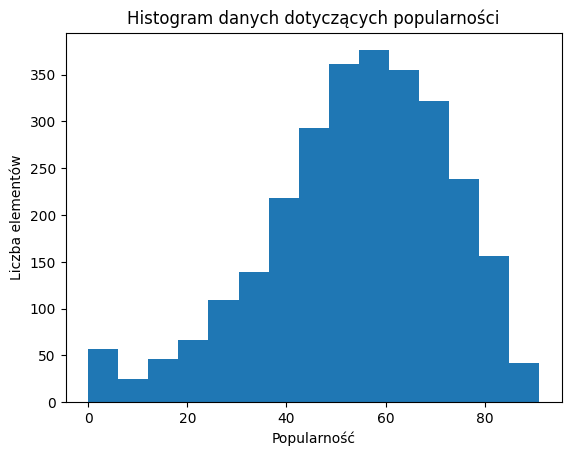

Text(0.5, 1.0, 'Rozkład popularności')

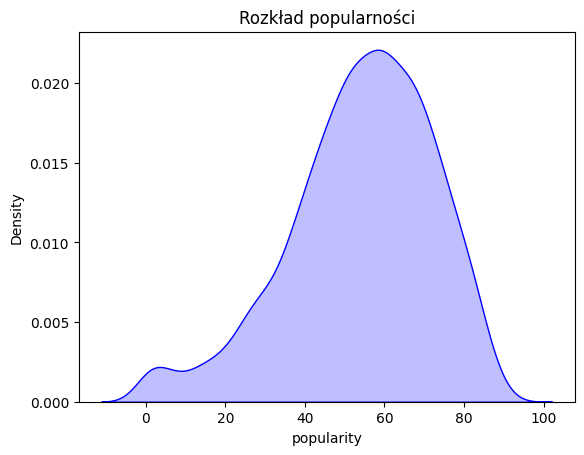

In [9]:
# Histogram of popularity
plt.hist(popularity, bins=15)
plt.xlabel('Popularność')
plt.ylabel('Liczba elementów')
plt.title('Histogram danych dotyczących popularności')
plt.show()


# density function
sns.kdeplot(popularity, color="blue",fill=True)
plt.title("Rozkład popularności")

#### Wizualizacja zależności między zmienną celu (*target*), a cechami (*features*).

Funkcja rysująca wykres punktowy zależności wartości zmiennej ```popularity``` od zmiennej *x*:

In [82]:
def plot_relationship(x_column, x_label, y_label, title,y_column=popularity):
    sns.scatterplot(x=x_column, y=y_column)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

##### Duration [s]

*   Można zauważyć, iż długość utworu ma nikły wpływ na popularność utworu - wiele utworów o podobnej długości ma diametralnie różną popularność. Nie należy się spodziewać pojawienia się trendu nawet po skalowaniu tej kolummy danych.

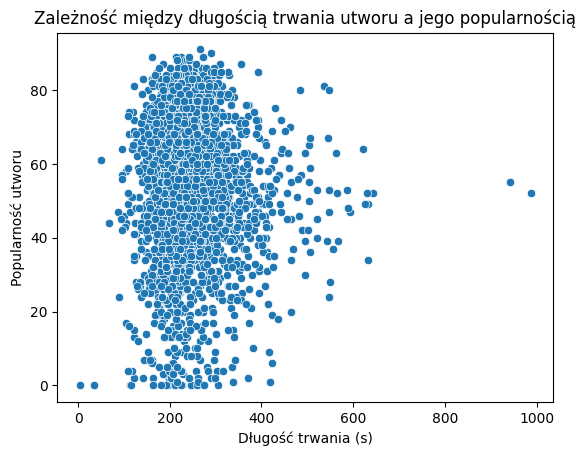

In [83]:
# all durations in seconds
duration_s = X_train["duration_ms"].values / 1000

# Scatter plot
plot_relationship(
    duration_s,
    x_label="Długość trwania (s)",
    y_label="Popularność utworu",
    title="Zależność między długością trwania utworu a jego popularnością",
)

##### Explicit

*   Na podstawie pierwszego wykresu można zauważyć, iż jest nieznacznie mniej utworów z niską popularnością (do 40), a także niewiele więcej utworów z wysoką (od 70) oraz średnią popularnością (40-70) posiadających ```explicit=True```. Fakt ten może świadczyć o pewnej korelacji między tym parametrem a popularnością utworu. 
*   Należy jednak zauważyć, iż utworów z ```explicit=False``` jest kilkukrotnie więcej - co obrazuje wykres drugi. Możliwym jest, iż taka dysproporcja danych bezpośrednio wpływa na kszałt wykresu pierwszego i wnioski z punktu wyżej w rzeczywistości nie są słuszne.

<Axes: xlabel='explicit', ylabel='popularity'>

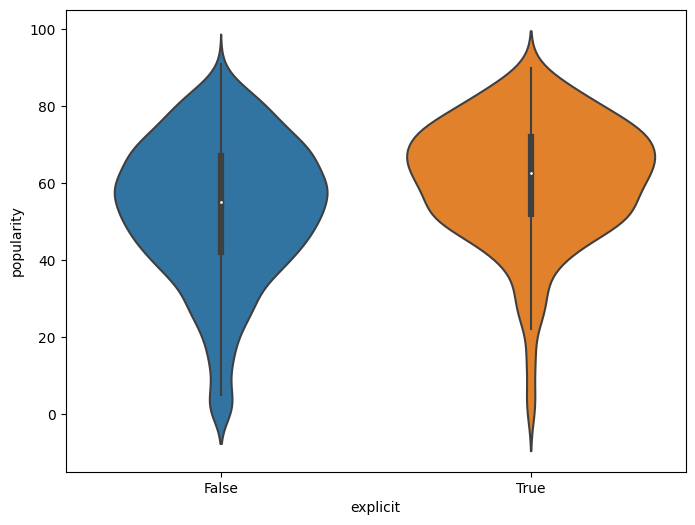

In [84]:
# all values of feature 'explicit'
explicit = X_train['explicit']

# ploting violinplot
plt.figure(figsize=(8,6))
sns.violinplot(x=explicit, y=popularity)

Text(0.5, 1.0, "Liczba utworów z daną wartością parametru 'explicit'")

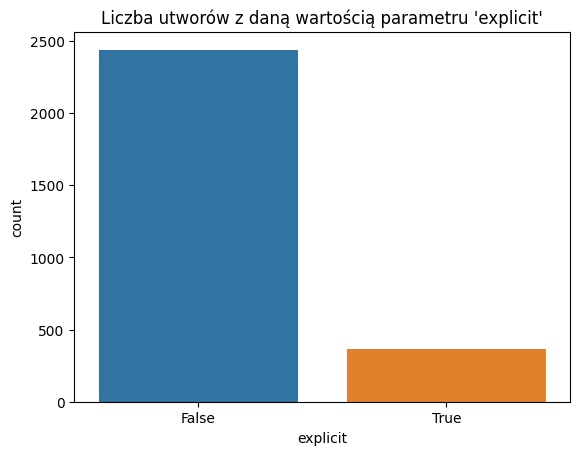

In [85]:
# ploting countplot
sns.countplot(x=explicit)
plt.title("Liczba utworów z daną wartością parametru 'explicit'")

##### Popularity per artist

*   W relacji popularności przypadającej na artystę oraz popularności utworu można dojrzeć korelację - im wyższa popularność przypadająca na artystę tym także wedle trendu wyższa popularność utworu.

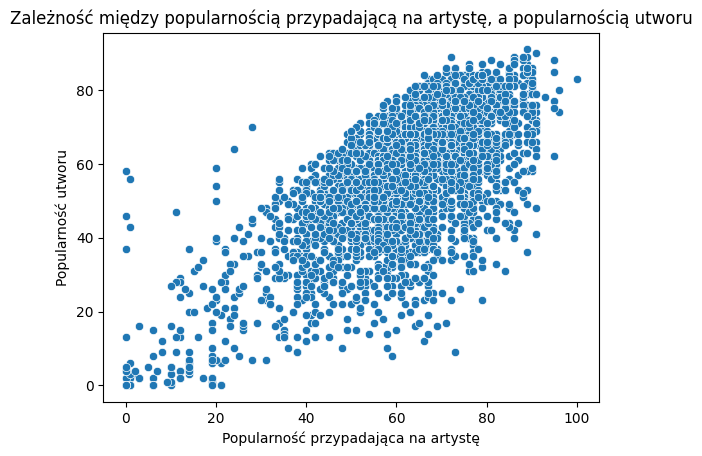

In [86]:
# all popularities per artist
pop_per_artist = X_train["popularity_per_artist"]

# Scatter plot
plot_relationship(
    pop_per_artist,
    "Popularność przypadająca na artystę",
    "Popularność utworu",
    "Zależność między popularnością przypadającą na artystę, a popularnością utworu",
)

##### Followers per artist

*   Zależność popularności utworu od średniej liczby obserwujących (w milionach) wydaje się być logarytmiczna. Może być to jednak spowodowane konkretnym podziałem zbioru danych na testowy i treningowy, dla którego wspomniana zależność występuje.

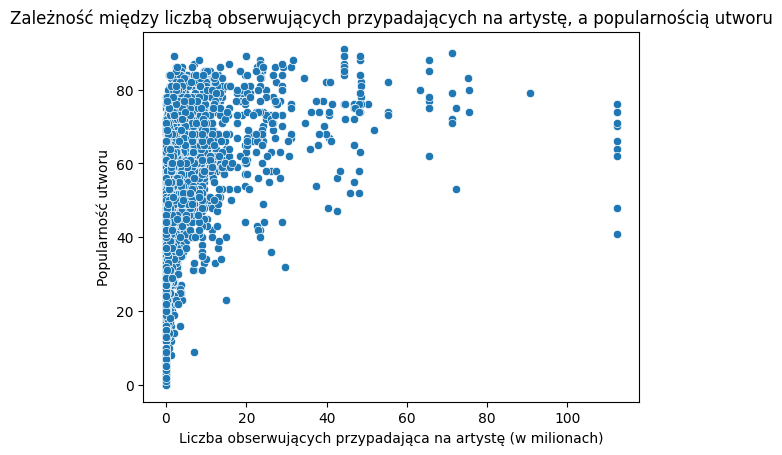

In [87]:
# all followers per artist (in millions)
foll_per_artist = X_train["followers_per_artist"] / 1000000

# Scatter plot
plot_relationship(
    foll_per_artist,
    "Liczba obserwujących przypadająca na artystę (w milionach)",
    "Popularność utworu",
    "Zależność między liczbą obserwujących przypadających na artystę, a popularnością utworu",
)

##### Album popularity

*   Badając wpływ popularności albumu na popularność utworu, który w nim jest zawarty można dostrzec trend - wraz ze wzrostem popularności albumu często rośnie także popularność utworu.
*   Problem jednak może stanowić podzbiór wartości popularności albumu równych **0**, dla których popularność utworu jest rozłożona na całą skalę możliwych wartości - z danych wynika, iż niepopularny album może zawierać bardzo lub wcale niepopularne utwory. Prawdopodobnie są to wszystkie te przypadki, gdzie z niszowego albumu wyłania się mniejszy, bądź większy "hit".

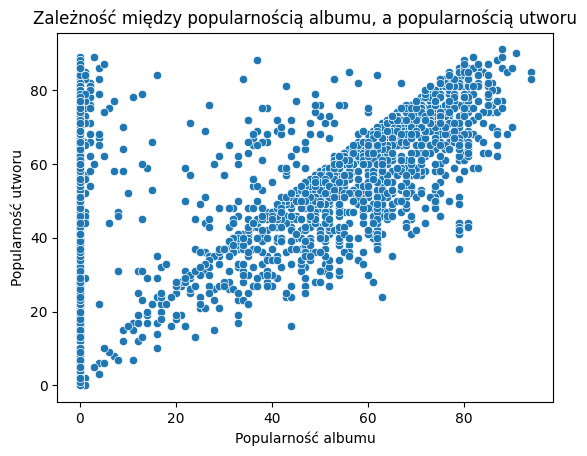

In [88]:
# all album popularities
album_pop = X_train["album_popularity"]

# Scatter plot
plot_relationship(
    album_pop,
    "Popularność albumu",
    "Popularność utworu",
    "Zależność między popularnością albumu, a popularnością utworu",
)


## Wstępne przetwarzanie danych

Usunięcie zbędnych kolumn niewnoszących znaczących informacji do analizy lub służących jedynie do identyfikacji obiektów:

In [89]:
columns_to_drop = [
    "track_name",
    "track_id",
    "artists",
    "artists_ids",
    "album_name",
    "album_id",
    "duration_ms",
]
for X in Xs:
    X.drop(columns_to_drop, axis=1, inplace=True)


Mapowanie wartości logicznych w kolumnie ```explicit```: False -> 0, True -> 1

In [90]:
for X in Xs:
    X['explicit'] = X['explicit'].replace({False: 0, True: 1})

X_train.head()

,explicit,popularity_per_artist,followers_per_artist,album_popularity
1961,0,54,193888,0
1971,0,52,377223,0
631,1,78,11294908,67
1563,0,59,2403891,0
3456,0,76,6673952,0


Sprawdzenie liczebności outlierów (wartości *0*) w kolumnie ```album_popularity```:

In [91]:
outliers_count = len(X_train[X_train['album_popularity'] == 0])
ratio = outliers_count / len(X_train)
ratio

0.4241883696039957

<font color='red'>Spostrzeżenie:</font><br>
Z racji, iż outliery stanowią znaczną część (*42%*) zbioru wartości cechy ```album_popularity``` rozsądnym wydaje się zakładać, iż mają one znaczącą rolę w zbiorze danych. Zatem uzupełnienie ich średnimi wartościami bądź usunięcię ze zbioru danych może wiązać się z utratą ważnych informacji.

Zastąpienie kolumny ```followers_per_artist``` jej logarytmem naturalnym, aby uzyskać zależność przypominającą liniową:

In [92]:
for X in Xs:
     X['followers_per_artist'] = np.log(X['followers_per_artist'])

X_train.head()

,explicit,popularity_per_artist,followers_per_artist,album_popularity
1961,0,54,12.175036,0
1971,0,52,12.840592,0
631,1,78,16.239863,67
1563,0,59,14.692599,0
3456,0,76,15.713723,0


Finalna Macierz korelacji

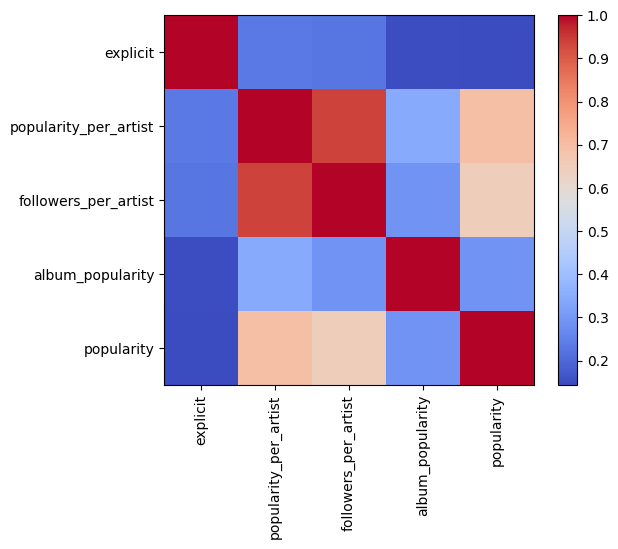

In [96]:
# merging modified X_train with y_train to get all the correlations
train = pd.concat([X_train, y_train], axis=1)
correlation_matrix = train.corr()

# displaying colorbar which is showing correlation matrix between features and target
plt.imshow(correlation_matrix, cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation='vertical')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

<font color='red'>Spostrzeżenie:</font><br>
Z faktu, iż analiza danych wykazała różną siłę zależności pomiędzy cechami a zmienną celową warto zdecydować się na wybór tych cech, które mogą być najbardziej użyteczne w trenowaniu modeli.

Wybór najistotniejszych cech za pomocą obiektu klasy ```SelectKBest```:

In [21]:
# creating SelectKBest (k=2) object with chosen measure of significance (chi-2)
selector = SelectKBest(score_func=chi2, k=2)

# fitting object to data
selector.fit_transform(X_train, y_train)

# choosing best features
selected_features = selector.get_support(indices=True)

print("Wybrane cechy:", selected_features)


Wybrane cechy: [1 3]


Zgodnie z dopasowaniem ```selectora``` do danych najtrafniejszymi cechami okazują się być: ```popularity_per_artist``` oraz ```album_popularity```.

Wybieranie najistotniejszych cech ze zbioru treningowego i testowego:

In [45]:
# selecting features chosen by selector
for i,X in enumerate(Xs):
     Xs[i] = Xs[i][Xs[i].columns[list(selected_features)]]

# changing X_train and X_test
X_train = Xs[0]
X_test = Xs[1]
X_train.head(), X_test.head()

(      popularity_per_artist  album_popularity
 1961                     54                 0
 1971                     52                 0
 631                      78                67
 1563                     59                 0
 3456                     76                 0,
       popularity_per_artist  album_popularity
 3151                     68                54
 315                      80                63
 2178                     56                44
 2772                     38                37
 430                      55                72)

## Tworzenie modeli

Z racji tego, iż problem dotyczy predykowania wartości popularności utworów można go zaklasyfikować jako problem ***regresji***. Do jego rozwiązania posłużą modele **regresji liniowej** (*LinearRegression*) oraz **regresji wektorów nośnych** (*SVR*).

Do znalezienia najlepszych kombinacji parametrów modeli użyty zostanie obiekt klasy ```GridSearchCV```:

In [46]:
def find_best_parameters(model, parameters, X, y, cv=10, verbose=1, n_jobs=-1):
    grid_object = GridSearchCV(
        model,
        parameters,
        scoring=make_scorer(r2_score),
        cv=cv,
        verbose=verbose,
        n_jobs=n_jobs,
    )
    grid_object = grid_object.fit(X, y)
    return grid_object.best_estimator_


### Regresja liniowa

In [47]:
# creating model
linear_regression = LinearRegression()

# params to choose
linear_regression_params = {
    "fit_intercept": [True, False],
    "copy_X": [True, False],
    "positive": [True, False],
}

# best found linear regression model
linear_regression = find_best_parameters(
    linear_regression, linear_regression_params, X_train, y_train
)


Fitting 10 folds for each of 8 candidates, totalling 80 fits


### Regresja wektorów nośnych

In [48]:
# creating model
svr = SVR()

# params to choose
svr_parameters = {
    "C": [1.0, 2.0, 4.0],
    "gamma": [0.001, 0.1, 1.0, 10.0],
}
# best found svr model
svr = find_best_parameters(svr, svr_parameters, X_train, y_train["popularity"])


Fitting 10 folds for each of 12 candidates, totalling 120 fits


## Ocena modeli

Stworzenie struktury do przechowywania używanych modeli:

In [49]:
models = [linear_regression, svr]

Do oceny modeli zostaną wykorzystane metryki:<br> 
*   ```mean_squared_error``` - mierzy ona średnią kwadratową różnicę między wartościami przewidywanymi przez model a rzeczywistymi wartościami obserwowanymi.
*   ```r2_score``` - wskazuje, jaki procent wariancji zmiennej objaśnianej może zostać wyjaśniony przez model.
*   ```root_mean_square_error``` - pierwiastek z ```mean_squared_error```, który daje wynik w tej samej jednostce co wartości rzeczywiste, co ułatwia interpretację.

Aby zapobiec wpływowi konkretnego podziału danych na ostateczną ocenę modelu dokonywana jest ***5-częściowa walidacja krzyżowa***, której otrzymane wyniki są uśredniane dla każdej stosowanej w ocenie metryki.

In [50]:
scoring = {
    "R^2 Score": make_scorer(r2_score),
    "MSE": make_scorer(mean_squared_error),
    "RMSE": make_scorer(mean_squared_error, squared=False),
}


# a function which evaluates model with metrics given in 'scoring'
def evaluate_regression_model(model, X, y, cv=5, scoring=scoring):
    scores = {}
    for metric, score in scoring.items():
        scores[metric] = np.mean(
            cross_val_score(estimator=model, X=X, y=y, cv=cv, scoring=score)
        )
    return scores

Pętla wyświetlająca dla każdego modelu jego ocenę określoną poprzez podane w ```scoring``` metryki:

In [57]:
models_scores = {}
for model in models:
    models_scores[model.__class__.__name__] = evaluate_regression_model(
        model, X_train, y_train["popularity"], 5
    )
    print(f"model: {model} --> {models_scores[model.__class__.__name__]}")


model: LinearRegression(positive=True) --> {'R^2 Score': 0.48161149144973, 'MSE': 171.06780712890478, 'RMSE': 13.078481802333437}
model: SVR(C=4.0, gamma=0.001) --> {'R^2 Score': 0.5809094781406683, 'MSE': 138.48322957850763, 'RMSE': 11.763968250509276}


## Podsumowanie

### Wizualizacja wyników

In [67]:
# names of models
models = list(models_scores.keys())

# creating dictionary to plot all metrics scores
metrics_scores = {}

r2_scores = [models_scores[model]["R^2 Score"] for model in models]
metrics_scores["R^2 Score"] = r2_scores
mses = [models_scores[model]["MSE"] for model in models]
metrics_scores["Mean Square Error"] = mses
rmses = [models_scores[model]["RMSE"] for model in models]
metrics_scores["Root Mean Square Error"] = rmses


# defining a function which draws bar chart which displays differences between models
def draw_bar_chart(labels, values, xlabel="", ylabel="", title=""):
    _, ax = plt.subplots()
    x = range(len(labels))

    ax.bar(x, values)

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


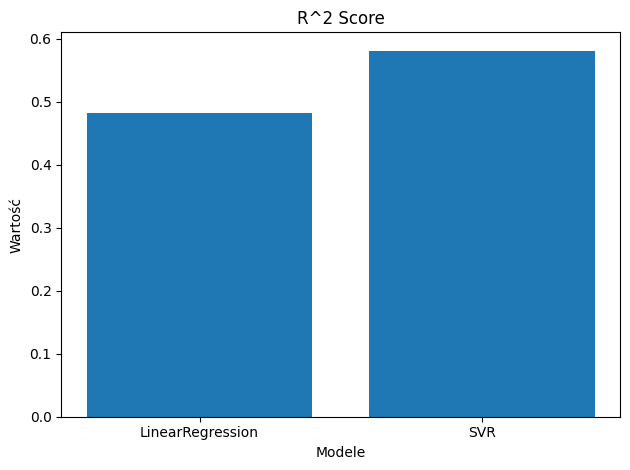

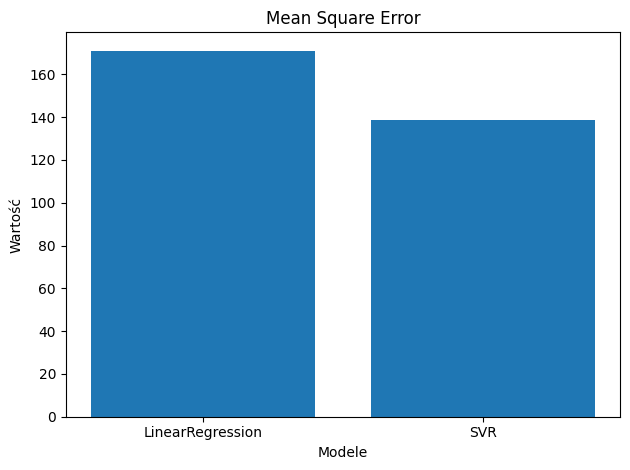

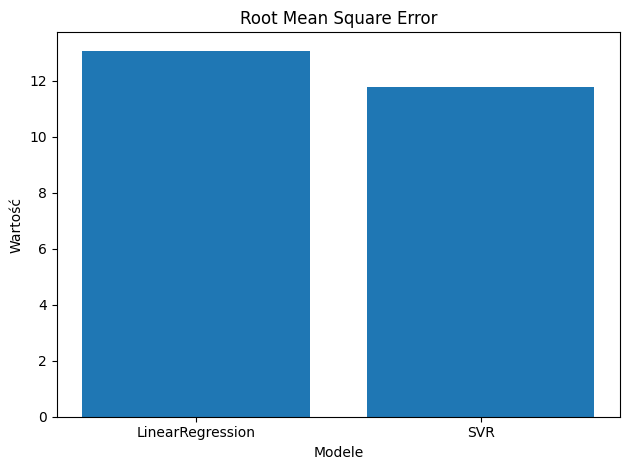

In [68]:
for metric, scores in metrics_scores.items():
    draw_bar_chart(models,scores,"Modele","Wartość", metric)

### Wnioski

*   Można stwierdzić, że dla podanych wyżej parametrów i cech model SVR (Support Vector Regression) osiąga lepsze wyniki niż model LinearRegression w problemie oceny popularności utworów ze <font color='green'>Spotify</font>.
*   Posiada on wyższy R^2 Score (0.5809 w porównaniu do 0.4816) oraz niższe wartości MSE i RMSE (138.4832 i 11.7640 w porównaniu do 171.0678 i 13.0785), co wskazuje na mniejsze błędy predykcji i lepsze dopasowanie do danych.
*   Oba modele mają wartości R^2 Score wyższe od 0, co sugeruje, że mają pewne zdolności przewidywania popularności piosenek. Jednakże, wartości te wskazują, że nadal istnieje znaczna wariancja, której modele nie są w stanie wyjaśnić.
*   W przypadku obu modeli, wartości MSE oraz RMSE są stosunkowo wysokie, co sugeruje, że modele mają tendencję do popełniania znacznych błędów w przewidywaniu popularności piosenek.
*   Uzyskany model ```SVR``` objaśnia około 58% wariancji w popularności utworów (*48%* w przypadku ```LinearRegression```) oraz myli się z predykcją jego popularności o średnio *11.764* (*13.078* ```LinearRegression```).
*   Mimo wszystko uzyskane wyniki można uznać za zadowalające, zważając na fakt, iż jest to alternatywne podejście do oceny popularności utworów do tego proponowanego przez autorów zbioru danych z <font color='green'>Web API Spotify</font>. Popularność utworu jest przez nich mierzona na podstawie liczby odsłuchań utworu oraz jego aktualności.